In [6]:
import os
from datasets import load_dataset
from PIL import Image
import pandas as pd
from easyocr import Reader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import pytesseract


In [7]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full content of each column (no truncation)
pd.set_option('display.width', None)

In [8]:
dataset = load_dataset("ahmedheakl/arocrbench_patsocr",split="train")


train-00000-of-00001.parquet:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [10]:
results = []
for sample in dataset:
    image = sample["image"]  # Already a PIL Image object
    if image.mode != "RGB":
        image = image.convert("RGB")
    ground_truth = sample["answer"]
    results.append({
        "image": image,
        "ground_truth": ground_truth,
        "tesseract": None,
        "easyocr": None,
    })
print(f"Initialized results with {len(results)} samples.")

Initialized results with 500 samples.


### Tesseract Processing

In [11]:
for i, sample in enumerate(results):
    image = sample["image"]
    tesseract_text = pytesseract.image_to_string(image,lang='ara')
    results[i]['tesseract'] = tesseract_text
print("Tesseract Processing completeed")

Tesseract Processing completeed


## EasyOCR

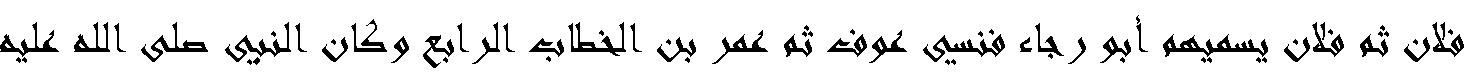

In [14]:
dataset[0]['image']

In [16]:
import numpy as np 
easyocr_reader = Reader(['ar'], gpu=True)
for i, sample in enumerate(results):
    image = sample["image"]
    image_np = np.array(image)
    easyocr_result = easyocr_reader.readtext(image_np, detail=0)
    easyocr_text = " ".join(easyocr_result)
    results[i]["easyocr"] = easyocr_text
print("EasyOCR processing completed.")

EasyOCR processing completed.


In [17]:
import re

def remove_diacritics(text):
    # Define Arabic diacritics using Unicode ranges
    diacritics = [
        '\u0617', '\u0618', '\u0619', '\u061A',  # Small high signs
        '\u064B', '\u064C', '\u064D', '\u064E', '\u064F', '\u0650',  # Tanween and basic diacritics
        '\u0651', '\u0652', '\u0653', '\u0654', '\u0655', '\u0656',  # Shadda, sukun, etc.
        '\u0657', '\u0658', '\u0659', '\u065A', '\u065B', '\u065C', 
        '\u065D', '\u065E', '\u065F', '\u0670'   # Additional Arabic diacritics
    ]
    # Create a regex pattern to match any diacritic
    pattern = '[' + ''.join(diacritics) + ']'
    # Replace all diacritics with an empty string
    return re.sub(pattern, '', text)

In [18]:
df = pd.DataFrame(results)
df.head()

,image,ground_truth,tesseract,easyocr
0,<PIL.Image.Image image mode=RGB size=1464x77 at 0x7FA20224B9D0>,فلان ثم فلان يسميهم أبو رجاء فنسي عوف ثم عمر بن الخطاب الرابع وكان النبي صلى الله عليه\n,فلآن ثه فلان يسميعه أيو رجاء فنسي عونت ثو عفر بن الخطابيه الرايع وحان التنيي حلي الله علية\n,صلى الله غليه النطاب الرابع وحان رجاء فنسبى غوف ثه عمر نان ثه نان يسميهم ا ربل النبب
1,<PIL.Image.Image image mode=RGB size=1187x75 at 0x7FA2016E3390>,معي صبرا قال لا تؤاخذني بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب\n,معي صبرا قال لا تؤاحذى بما نسيت فكانت الأولى من موسى نسيانا فانطلا فإذا غلام يلعب\n,صبرا قال لا تؤاخذني بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب
2,<PIL.Image.Image image mode=RGB size=1985x60 at 0x7FA1FA283210>,في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده\n,فى الاتنتين ويفعل ذلك فى كل ركعة حتى يفرغ من الصلاة تم يقول حين ينصرف والذي نفسى بيده\n,كل ركعة حتى يفرغ من الصلاة ثه يقول حين ينصرف والذي نفسى بيده ويفعل ذلك فى الاثنتين في
3,<PIL.Image.Image image mode=RGB size=1242x105 at 0x7FA1FA282C10>,صلى الله عليه وسلم خرج حين زاغت الشمس فصلى الظهر فقام على المنبر فذكر الساعة فذكر أن\n,صلى الله عليه وسلم خريج حين زاغت الشمس فصلى الظهر فقام على المتبر فذكر الساعة فذكر أن\n,_فذكر الساعة فذكران فصلى الظهر فقام على الله عليه وسلم خرج حين زاغت المنبر الشمس
4,<PIL.Image.Image image mode=RGB size=1552x57 at 0x7FA204F63610>,ليتني فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم\n,ليتني فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم\n,حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم ليتني فيها جذع أكون ليتني


In [19]:

df['ground_truth_t'] = df["ground_truth"].apply(remove_diacritics)
df['tesseract_t'] = df["tesseract"].apply(remove_diacritics)
df['easyocr_t'] = df["easyocr"].apply(remove_diacritics)

In [20]:
df.head()


,image,ground_truth,tesseract,easyocr,ground_truth_t,tesseract_t,easyocr_t
0,<PIL.Image.Image image mode=RGB size=1464x77 at 0x7FA20224B9D0>,فلان ثم فلان يسميهم أبو رجاء فنسي عوف ثم عمر بن الخطاب الرابع وكان النبي صلى الله عليه\n,فلآن ثه فلان يسميعه أيو رجاء فنسي عونت ثو عفر بن الخطابيه الرايع وحان التنيي حلي الله علية\n,صلى الله غليه النطاب الرابع وحان رجاء فنسبى غوف ثه عمر نان ثه نان يسميهم ا ربل النبب,فلان ثم فلان يسميهم أبو رجاء فنسي عوف ثم عمر بن الخطاب الرابع وكان النبي صلى الله عليه\n,فلآن ثه فلان يسميعه أيو رجاء فنسي عونت ثو عفر بن الخطابيه الرايع وحان التنيي حلي الله علية\n,صلى الله غليه النطاب الرابع وحان رجاء فنسبى غوف ثه عمر نان ثه نان يسميهم ا ربل النبب
1,<PIL.Image.Image image mode=RGB size=1187x75 at 0x7FA2016E3390>,معي صبرا قال لا تؤاخذني بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب\n,معي صبرا قال لا تؤاحذى بما نسيت فكانت الأولى من موسى نسيانا فانطلا فإذا غلام يلعب\n,صبرا قال لا تؤاخذني بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب,معي صبرا قال لا تؤاخذني بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب\n,معي صبرا قال لا تؤاحذى بما نسيت فكانت الأولى من موسى نسيانا فانطلا فإذا غلام يلعب\n,صبرا قال لا تؤاخذني بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب
2,<PIL.Image.Image image mode=RGB size=1985x60 at 0x7FA1FA283210>,في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده\n,فى الاتنتين ويفعل ذلك فى كل ركعة حتى يفرغ من الصلاة تم يقول حين ينصرف والذي نفسى بيده\n,كل ركعة حتى يفرغ من الصلاة ثه يقول حين ينصرف والذي نفسى بيده ويفعل ذلك فى الاثنتين في,في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده\n,فى الاتنتين ويفعل ذلك فى كل ركعة حتى يفرغ من الصلاة تم يقول حين ينصرف والذي نفسى بيده\n,كل ركعة حتى يفرغ من الصلاة ثه يقول حين ينصرف والذي نفسى بيده ويفعل ذلك فى الاثنتين في
3,<PIL.Image.Image image mode=RGB size=1242x105 at 0x7FA1FA282C10>,صلى الله عليه وسلم خرج حين زاغت الشمس فصلى الظهر فقام على المنبر فذكر الساعة فذكر أن\n,صلى الله عليه وسلم خريج حين زاغت الشمس فصلى الظهر فقام على المتبر فذكر الساعة فذكر أن\n,_فذكر الساعة فذكران فصلى الظهر فقام على الله عليه وسلم خرج حين زاغت المنبر الشمس,صلى الله عليه وسلم خرج حين زاغت الشمس فصلى الظهر فقام على المنبر فذكر الساعة فذكر أن\n,صلى الله عليه وسلم خريج حين زاغت الشمس فصلى الظهر فقام على المتبر فذكر الساعة فذكر أن\n,_فذكر الساعة فذكران فصلى الظهر فقام على الله عليه وسلم خرج حين زاغت المنبر الشمس
4,<PIL.Image.Image image mode=RGB size=1552x57 at 0x7FA204F63610>,ليتني فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم\n,ليتني فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم\n,حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم ليتني فيها جذع أكون ليتني,ليتني فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم\n,ليتني فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم\n,حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم ليتني فيها جذع أكون ليتني


In [21]:
from jiwer import wer, cer 

for model in ["tesseract","easyocr"]:
    wer_score = wer(df["ground_truth"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

tesseract - WER: 0.30, CER: 0.14
easyocr - WER: 0.74, CER: 0.55


In [22]:
from jiwer import wer, cer 

for model in ["tesseract_t","easyocr_t"]:
    wer_score = wer(df["ground_truth_t"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth_t"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

tesseract_t - WER: 0.30, CER: 0.14
easyocr_t - WER: 0.74, CER: 0.55


In [23]:
df.to_csv("khattat_patsocr_result.csv")


: 